## import packages

In [1]:
import sys
import time
from pathlib import Path
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

from sklearn.calibration import CalibrationDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pickle 

from sklearn.model_selection import StratifiedKFold

## set up for imports of .py modules by adding path to sys.path

In [2]:
# Get the current working directory
cwd = Path(os.getcwd())

# Set the current working directory to its parent
parent_cwd = cwd.parent
os.chdir(parent_cwd)

# Verify the change
print(f"Current working directory changed to: {os.getcwd()}")

Current working directory changed to: /Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/roux_class_files/DS5220/final_project/customer-segmentation


## import python modules

In [3]:
import utils.sml_utils as sml_utils
import utils.bin_class_utils as class_utils
import utils.glue_old_to_new as gotn
import utils.assign_and_lab_utils as al_utils
import utils.classification_utils as class_utils_2
import utils.reg_model_selection_utils as reg_ms_utils

## helpful functions

In [4]:
print('no functions')  # all helpful functions should go in this cell to preserve the cell count

no functions


## parameters

In [ ]:
# path to data
path_to_data = 'data/data_splits/train_df.csv'
task = 'classification'

# step 1 parameters - check for missingness in target vector
target_attr = 'Segmentation'
class_labels = ['B', 'D']

# step 2 parameters

# step 3 parameters - train/test split
test_size = 0.20
train_test_split_random_state = 42

# step 4 parameters - train/validation split
train_validation_split = False
val_size = 0.30
train_validation_split_random_state = 42

# step 4.25 parameters - ttrain/probability calibration split
train_prob_cal_split = True  # used to calibrate classifier probability
train_prob_cal_split_random_state = 42
train_prob_cal_split_size = 0.20

# step 4.5 parameters - train/classification threshold tuning split
train_class_threshold_tune_split = True  # used to set the classification threshold
train_class_threshold_tune_split_random_state = 42
train_class_threshold_tune_split_size = 0.20

# step 5 parameters - identify attributes with missingness above threshold
missingness_threshold = 0.20

# step 11 parameters - build a composite estimator
sgd_class_random_state = 42
target_encoder_random_state = 42
class_weight = 'balanced'
rf_random_state = 42
dtc_stub_random_state = 42
adaboost_random_state = 42
svc_random_state = 42

# transformer parameters
nominal_imputer_strategy = "most_frequent"
numerical_imputer_strategy = "mean"

# step 12 parameters - model selection / model assessment parameters cross validation parameters
scoring = ['neg_log_loss']  # must be in a list even if only one scoring metric
kwargs = {'return_indices': False}  # if true the indices of the cross validation split are returned
max_iter = 1000  # max number of epochs for SGDClassifier

# step 12 parameters - maximal control k-fold cross validation splitter parameters
kfold_n_splits = 10  # number of folds in k-fold cross validation
kfold_shuffle = True
kfold_random_state = 42

# step 14 parameters - tune hyperparameters of short-listed composite estimators
gs_cv_kfold_n_splits = 10
gs_cv_kfold_shuffle = True
gs_cv_kfold_random_state = 24
show_all_params = True
speed_up = False  # if True random stratified sample taken before GridSearchCV
frac = 0.10  # fraction taken for speed up
spd_up_random_state = 42  # speed up random state

# step 16 parameters - calibrate the classifiers
calibrate_classifiers = True
frac_of_val_for_cal = 0.5  # 1 - frac to validate cal

# step 18 parameters - model selection - configured for no model selection
script_select = False  # default = False - True if you want to let the script select the model with the lowest log loss out of GridsearchCV
hand_select = False  # default = False - if True you must select a model by hand and identify the model row index in grid_search_cv_results_df
hand_select_index = None # do not change this line
if hand_select:
    hand_select_index = None  # default = None - if hand select enter best model index from grid_search_cv_results_df

# step 19 - tune classification threshold
classification_threshold = None  # default = None

## set up to time script run time

In [6]:
start = time.time()

## read in the data and get the size of the data

In [7]:
df = pd.read_csv(path_to_data)
print(df.shape)
df.head()

(6454, 12)


,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,917,465905,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6,A
1,3398,462903,Male,Yes,72,Yes,Entertainment,NaN,Average,2.0,Cat_6,B
2,2045,467901,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6,B
3,8060,463613,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6,A
4,4604,459859,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7,A


## out of pipeline preprocessing

### These operations cannot be completed in the scikit-learn pipeline.

### They should be identified and passed on the the data engineer as tasks conducted during extract/transform/load (ETL) if the model goes to production.

## 1. check for missingness in target vector and dedup

In [8]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(6454, 12)
(6454, 12)


In [9]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(6454, 12)
(6454, 12)


## 2. label binarize

In [ ]:
df = df[df['Segmentation'].isin(class_labels)]


In [11]:
if pd.api.types.infer_dtype(df[target_attr]) == 'string':
    df, le_name_mapping = class_utils.label_binarize_binary(df, target_attr, print_results=True)
else:
    print(f'df[target_attr] is not a string attribute')


df[target_attr] is a string attribute

df.loc[0:5, target_attr]:
0    A
1    B
2    B
3    A
4    A
Name: Segmentation, dtype: object

Segmentation
A    0.515013
B    0.484987
Name: proportion, dtype: float64

label encode df[target_attr]

after label encoding df[target_attr]

Segmentation
0.0    0.515013
1.0    0.484987
Name: proportion, dtype: float64

df.loc[0:5, target_attr]:
0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: Segmentation, dtype: float64

lb_name_mapping: {0: 'A', 1: 'B'}


## 3. train/test split

In [12]:
train_cap_x_df, train_y_df = \
    sml_utils.perform_the_train_test_split(
    df, 
    test_size, 
    train_test_split_random_state, 
    val=False,
    stratify=True
)

*************************

df.shape:
(3064, 12)

target class fractional balance:
Segmentation
0.0    0.515013
1.0    0.484987
Name: count, dtype: float64

*************************

train_df.csv:
(2451, 11) (2451, 1)

target class fractional balance:
Segmentation
0.0    0.514892
1.0    0.485108
Name: count, dtype: float64

*************************

test_df.csv
(613, 11) (613, 1)

target class fractional balance:
Segmentation
0.0    0.515498
1.0    0.484502
Name: count, dtype: float64


## 4. train/validation split

In [13]:
if train_validation_split:
    train_cap_x_df, train_y_df = \
        sml_utils.perform_the_train_test_split(
            pd.concat([train_cap_x_df, train_y_df], axis=1), 
            val_size, 
            train_validation_split_random_state, 
            val=True,
            stratify=True
    )

## 4.25 train / probability calibration split

In [14]:
if train_prob_cal_split:
    train_cap_x_df, train_y_df = \
        sml_utils.perform_the_train_test_split(
            pd.concat([train_cap_x_df, train_y_df], axis=1), 
            train_prob_cal_split_size, 
            train_prob_cal_split_random_state, 
            prob_cal=True,
            stratify=True
    )

*************************

df.shape:
(2451, 12)

target class fractional balance:
Segmentation
0.0    0.514892
1.0    0.485108
Name: count, dtype: float64

*************************

train_df.csv:
(1960, 11) (1960, 1)

target class fractional balance:
Segmentation
0.0    0.514796
1.0    0.485204
Name: count, dtype: float64

*************************

prob_cal_set_df.csv
(491, 11) (491, 1)

target class fractional balance:
Segmentation
0.0    0.515275
1.0    0.484725
Name: count, dtype: float64


## 4.5 train / classification threshold tuning split

In [15]:
if train_class_threshold_tune_split:
    train_cap_x_df, train_y_df = \
        sml_utils.perform_the_train_test_split(
            pd.concat([train_cap_x_df, train_y_df], axis=1), 
            train_class_threshold_tune_split_size, 
            train_class_threshold_tune_split_random_state, 
            classification_threshold=True,
            stratify=True
    )

*************************

df.shape:
(1960, 12)

target class fractional balance:
Segmentation
0.0    0.514796
1.0    0.485204
Name: count, dtype: float64

*************************

train_df.csv:
(1568, 11) (1568, 1)

target class fractional balance:
Segmentation
0.0    0.514668
1.0    0.485332
Name: count, dtype: float64

*************************

class_thresh_set_df.csv
(392, 11) (392, 1)

target class fractional balance:
Segmentation
0.0    0.515306
1.0    0.484694
Name: count, dtype: float64


## 5. identify attributes with  missingness above threshold

In [16]:
return_dict = sml_utils.get_missingness(train_cap_x_df, missingness_threshold)
missingness_drop_list = return_dict['missingness_drop_list']

index missingness = 0.0
ID missingness = 0.0
Gender missingness = 0.0
Ever_Married missingness = 0.01594387755102041
Age missingness = 0.0
Graduated missingness = 0.008290816326530613
Profession missingness = 0.01594387755102041
Work_Experience missingness = 0.08864795918367346
Spending_Score missingness = 0.0
Family_Size missingness = 0.03571428571428571
Var_1 missingness = 0.008290816326530613

missingness_drop_list:
[]


## 6. identify non machine learning attributes

In [17]:
sml_utils.check_for_complete_unique_attrs(train_cap_x_df)

the data frame has 1568 rows

index has 1568 unique values and is dtype int64 examine more closely
ID has 1568 unique values and is dtype int64 examine more closely
Gender has 2 unique values and is dtype object 
Ever_Married has 2 unique values and is dtype object 
Age has 67 unique values and is dtype int64 
Graduated has 2 unique values and is dtype object 
Profession has 9 unique values and is dtype object 
Work_Experience has 15 unique values and is dtype float64 
Spending_Score has 3 unique values and is dtype object 
Family_Size has 9 unique values and is dtype float64 
Var_1 has 7 unique values and is dtype object 


['index', 'ID']

In [18]:
non_ml_attr_list = ['index', 'ID']

## 7. identify attributes to exclude from machine learning

In [19]:
train_cap_x_df.columns

Index(['index', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [20]:
ml_attr_drop_list = []

## 8. establish machine learning attribute configuration

In [21]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

['index', 'ID']

In [22]:
train_cap_x_df.columns

Index(['index', 'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated',
       'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size',
       'Var_1'],
      dtype='object')

In [23]:
df.dtypes

index                int64
ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation       float64
dtype: object

In [24]:
# identify the remaining numerical attributes to be used in machine learning and enter them into the 
# numerical_attr list below.

numerical_attr = ["Age", "Work_Experience", "Family_Size"]

# identify the remaining nominal attributes to be used in machine learning and enter them into the 
# nominal_attr list below.

nominal_attr = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))  # got them all?

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {nominal_attr}')

print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: ['index', 'ID']

numerical_attr: ['Age', 'Work_Experience', 'Family_Size']
nominal_attr: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

number of machine learning attributes: 9

numerical_attr and nominal_attr: ['Age', 'Work_Experience', 'Family_Size', 'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


## 9. assess target attribute imbalance

In [25]:
train_y_df[target_attr].unique().tolist()

[0.0, 1.0]

In [26]:
train_y_df[target_attr].value_counts(normalize=True)

Segmentation
0.0    0.514668
1.0    0.485332
Name: proportion, dtype: float64

## 10. steps to deal with target attribute imbalance if required

To be completed later.

## 11. build default composite estimators

### build a dictionary of default estimators

In [27]:
estimators_list = [

    ('SGDClassifier', SGDClassifier(
        loss='log_loss',  # 'hinge'
        penalty='l2', 
        alpha=0.0001, 
        l1_ratio=0.15, 
        fit_intercept=True, 
        max_iter=max_iter, 
        tol=0.001, 
        shuffle=True, 
        verbose=0, 
        epsilon=0.1, 
        n_jobs=-1,  # None
        random_state=sgd_class_random_state,  # None
        learning_rate='optimal', 
        eta0=0.0, 
        power_t=0.5, 
        early_stopping=True,  # False,
        validation_fraction=0.1, 
        n_iter_no_change=5, 
        class_weight=class_weight,  # None
        warm_start=False, 
        average=False)
    ),

    ('RandomForestClassifier', RandomForestClassifier(
        n_estimators=100,
        criterion='gini', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features='sqrt', 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        bootstrap=True, 
        oob_score=False, 
        n_jobs=-1,  # None, 
        random_state=rf_random_state,  # None
        verbose=0, 
        warm_start=False, 
        class_weight=class_weight,  # None
        ccp_alpha=0.0, 
        max_samples=None, 
        monotonic_cst=None)
    ),

    ('AdaBoostClassifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion='gini', 
            splitter='best', 
            max_depth=1,  # None
            min_samples_split=2, 
            min_samples_leaf=1, 
            min_weight_fraction_leaf=0.0, 
            max_features=None, 
            random_state=dtc_stub_random_state,  # None
            max_leaf_nodes=None, 
            min_impurity_decrease=0.0, 
            class_weight=class_weight, 
            ccp_alpha=0.0, 
            monotonic_cst=None
        ),
        n_estimators=50, 
        learning_rate=1.0, 
        algorithm='SAMME',
        random_state=adaboost_random_state)  # None
    ),

    ('KNeighborsClassifier', KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform', 
        algorithm='auto', 
        leaf_size=30, 
        p=2, 
        metric='minkowski', 
        metric_params=None, 
        n_jobs=None)
    ),

    ('SVC_Linear', SVC(
        kernel='linear',
        C=1.0, 
        probability=True, 
        shrinking=True, 
        tol=0.001, 
        cache_size=200, 
        verbose=False, 
        max_iter=-1, 
        decision_function_shape='ovr', 
        break_ties=False, 
        random_state=None)
    ),

    ('SVC_RBF', SVC(
        kernel='rbf',
        C=1.0, 
        probability=True, 
        shrinking=True, 
        tol=0.001, 
        cache_size=200, 
        verbose=False, 
        max_iter=-1, 
        decision_function_shape='ovr', 
        break_ties=False, 
        random_state=None)
    ),

    ('GaussianProcessClassifier', GaussianProcessClassifier(
        kernel=None, 
        optimizer='fmin_l_bfgs_b', 
        n_restarts_optimizer=0, 
        max_iter_predict=100, 
        warm_start=False, 
        copy_X_train=True, 
        random_state=None, 
        multi_class='one_vs_rest', 
        n_jobs=None)
    ),

    ('DecisionTreeClassifier', DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=None, 
        random_state=None, 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        class_weight=None, 
        ccp_alpha=0.0)
    ),

    ('MLPClassifier', MLPClassifier(
        hidden_layer_sizes=(100,), 
        activation='relu', 
        solver='adam', 
        alpha=0.0001, 
        batch_size='auto', 
        learning_rate='constant', 
        learning_rate_init=0.001, 
        power_t=0.5, 
        max_iter=200, 
        shuffle=True, 
        random_state=None, 
        tol=0.0001, 
        verbose=False, 
        warm_start=False, 
        momentum=0.9, 
        nesterovs_momentum=True, 
        early_stopping=False, 
        validation_fraction=0.1, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-08, 
        n_iter_no_change=10, 
        max_fun=15000)
    ),

    ('GaussianNB', GaussianNB(
        priors=None, 
        var_smoothing=1e-09)
    ),

    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis(
        priors=None, 
        reg_param=0.0, 
        store_covariance=False, 
        tol=0.0001)
    )
]

estimator_dict = {
    
    #estimators_list[0][0]: estimators_list[0][1],  # SGDClassifier

    estimators_list[1][0]: estimators_list[1][1],  # RandomForestClassifier
    
    estimators_list[2][0]: estimators_list[2][1],  # AdaBoostClassifier

    #estimators_list[3][0]: estimators_list[3][1],  # KNeighborsClassifier

    estimators_list[4][0]: estimators_list[4][1],  # SVC_Linear

    estimators_list[5][0]: estimators_list[5][1],  # SVC_RBF

    estimators_list[6][0]: estimators_list[6][1],  # GaussianProcessClassifier

    #estimators_list[7][0]: estimators_list[7][1],  # DecisionTreeClassifier

    estimators_list[8][0]: estimators_list[8][1],  # MLPClassifier

    estimators_list[9][0]: estimators_list[9][1],  # GaussianNB

    estimators_list[10][0]: estimators_list[10][1]  # QuadraticDiscriminantAnalysis

    # 'VotingClassifier': VotingClassifier(
    #     estimators=[
    #         (estimators_list[0][0], estimators_list[0][1]),  # SGDClassifier
    #         (estimators_list[1][0], estimators_list[1][1]),  # RandomForestClassifier
    #         (estimators_list[2][0], estimators_list[2][1])  # AdaBoostClassifier
    #     ],
    #     voting='soft',  # 'hard'
    #     weights=[1.0, 1.0, 1.0],  # None, 
    #     n_jobs=-1,  # None
    #     flatten_transform=True, 
    #     verbose=False
    # )
}

### build a preprocessing pipeline

In [28]:
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=numerical_imputer_strategy)),
        ("scaler", StandardScaler())
    ]
)

In [29]:
nominal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=nominal_imputer_strategy)),
        ("target_encoder", TargetEncoder(
                    categories='auto', 
                    target_type='binary', 
                    smooth='auto', 
                    cv=5, 
                    shuffle=True, 
                    random_state=target_encoder_random_state
                )
        ),
        ("scaler", StandardScaler())
    ]
)

In [30]:
preprocessor = ColumnTransformer(
        transformers=[
            ('nominal', nominal_transformer, nominal_attr),
            ('numerical', numerical_transformer, numerical_attr)
        ]
)

## 12. survey (fit and evaluate with cost function and ranking metrics)  default composite estimators

### survey candidate default models by fitting them on the whole train set

In [31]:
return_dict = sml_utils.model_survey_fit(preprocessor, estimator_dict, train_cap_x_df, train_y_df)
trained_estimator_dict = return_dict['trained_estimator_dict']

RandomForestClassifier
AdaBoostClassifier
SVC_Linear
SVC_RBF
GaussianProcessClassifier
MLPClassifier
GaussianNB
QuadraticDiscriminantAnalysis


/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### estimate the test error rate using k-fold cross validation - use KFold splitter

/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti


                    regressor_name score_name_ score_type     score
0              AdaBoostClassifier    log_loss       test  0.658634
1              AdaBoostClassifier    log_loss      train  0.646010
2                      GaussianNB    log_loss       test  0.676262
3                      GaussianNB    log_loss      train  0.659537
4       GaussianProcessClassifier    log_loss       test  0.657961
5       GaussianProcessClassifier    log_loss      train  0.562712
6                   MLPClassifier    log_loss       test  0.657861
7                   MLPClassifier    log_loss      train  0.589152
8   QuadraticDiscriminantAnalysis    log_loss       test  0.666455
9   QuadraticDiscriminantAnalysis    log_loss      train  0.626564
10         RandomForestClassifier    log_loss       test  0.662625
11         RandomForestClassifier    log_loss      train  0.459917
12                     SVC_Linear    log_loss       test  0.668694
13                     SVC_Linear    log_loss      train  0.

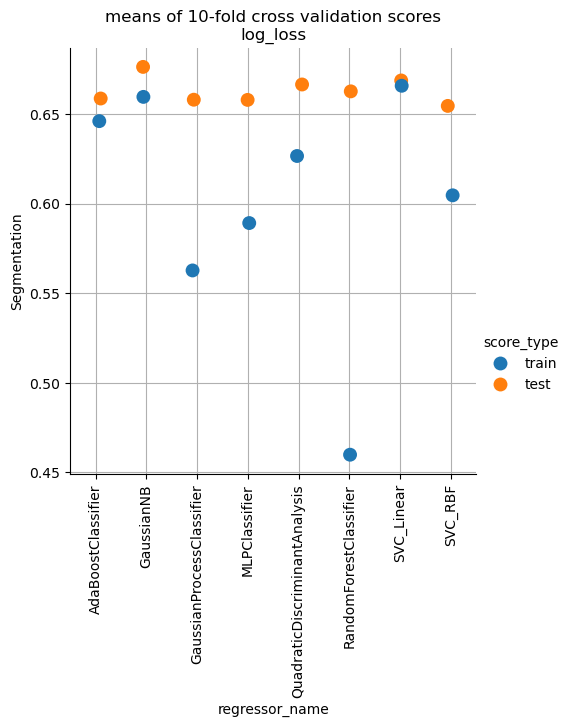

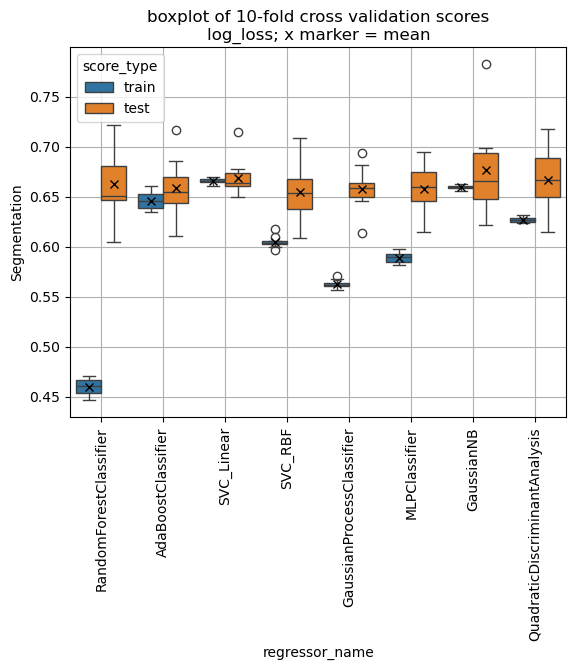

In [32]:
# get the maximal control k-fold cross validation splitter
splitter = StratifiedKFold(
    n_splits=kfold_n_splits,
    shuffle=kfold_shuffle,
    random_state=kfold_random_state
)
splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# perform cross validation on models
sml_utils.model_survey_cross_val_and_analysis(
    preprocessor, 
    estimator_dict, 
    train_cap_x_df, 
    train_y_df, 
    scoring, 
    splitter, 
    target_attr, 
    trained_estimator_dict, 
    task=task,
    **kwargs
)

### get the ranking metrics

/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mikey/miniconda3/envs/conda_usml_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti


                    regressor_name        score_name_ score_type     score
0              AdaBoostClassifier  average_precision       test  0.641009
1              AdaBoostClassifier  average_precision      train  0.647031
2              AdaBoostClassifier            roc_auc       test  0.662905
3              AdaBoostClassifier            roc_auc      train  0.679814
4                      GaussianNB  average_precision       test  0.647743
5                      GaussianNB  average_precision      train  0.649385
6                      GaussianNB            roc_auc       test  0.651173
7                      GaussianNB            roc_auc      train  0.667746
8       GaussianProcessClassifier  average_precision       test  0.644563
9       GaussianProcessClassifier  average_precision      train  0.819206
10      GaussianProcessClassifier            roc_auc       test  0.642502
11      GaussianProcessClassifier            roc_auc      train  0.840118
12                  MLPClassifier  a

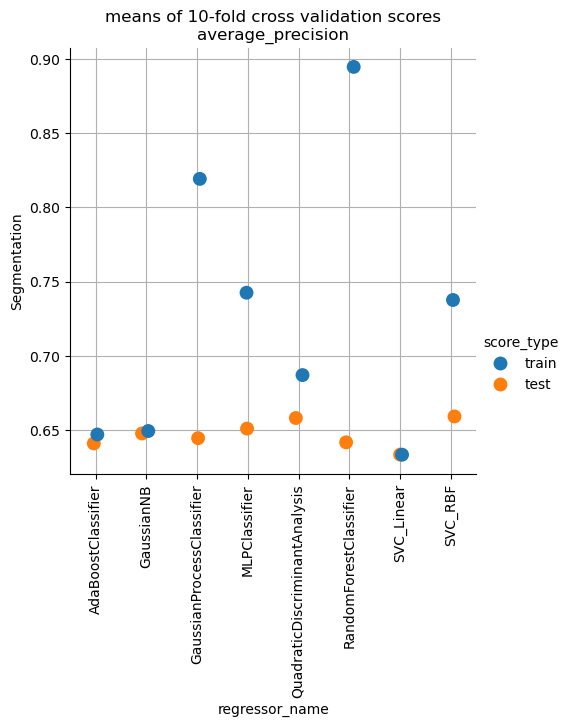

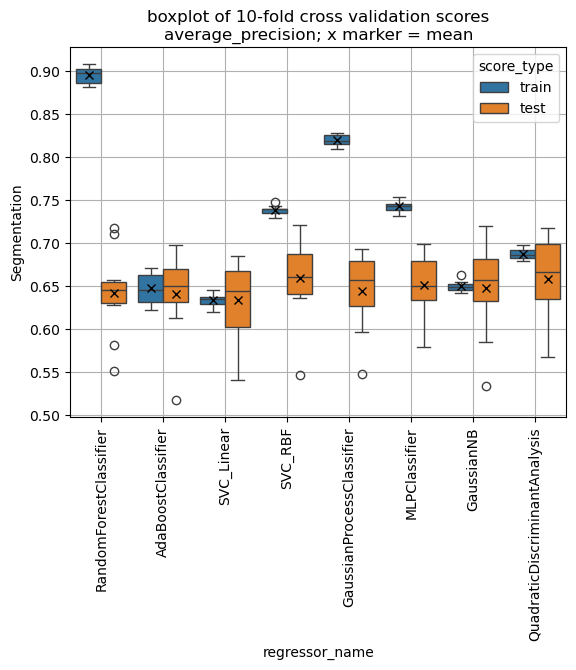

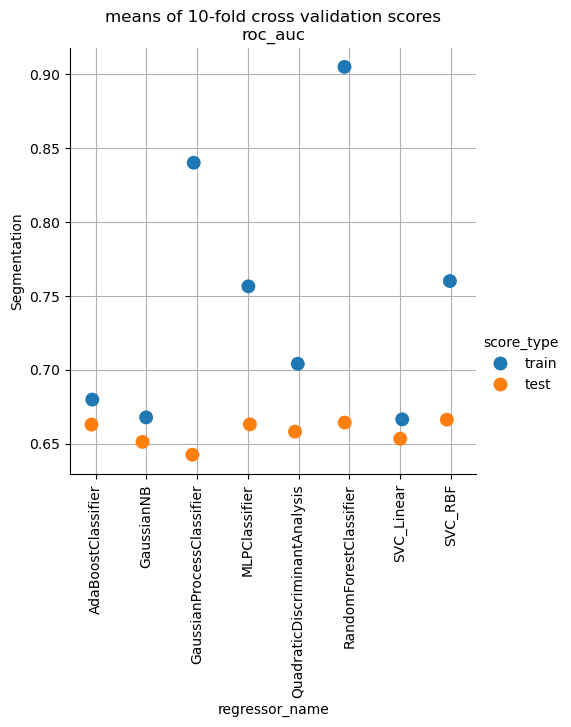

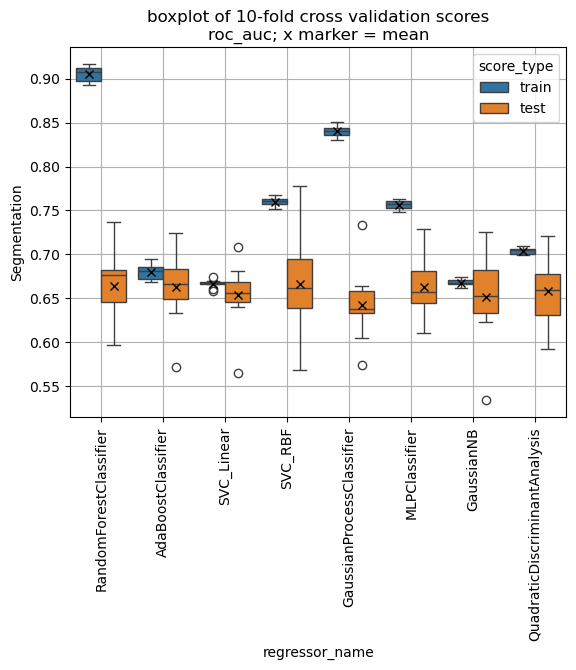

In [33]:
# get the maximal control k-fold cross validation splitter
splitter = StratifiedKFold(
    n_splits=kfold_n_splits,
    shuffle=kfold_shuffle,
    random_state=kfold_random_state
)
splitter.get_n_splits(train_cap_x_df, train_y_df[target_attr])

# perform cross validation on models
sml_utils.model_survey_cross_val_and_analysis(
    preprocessor=preprocessor, 
    estimator_dict=estimator_dict, 
    train_cap_x_df=train_cap_x_df, 
    train_y_df=train_y_df, 
    scoring=['average_precision', 'roc_auc'], 
    splitter=splitter, 
    target_attr=target_attr, 
    trained_estimator_dict=trained_estimator_dict, 
    task=task,
    **kwargs
)

## check out script run time

In [ ]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')